# Unit 5: Model-based Collaborative Filtering for **Rating** Prediction

In this unit, we change the approach towards CF from neighborhood-based to **model-based**. This means that we create and train a model for describing users and items instead of using the k nearest neighbors. The model parameters are latent representations for users and items.

Key to this idea is to compress the sparse interaction information of $R$ by finding two matrices $U$ and $V$ that by multiplication reconstruct $R$. The decomposition of $R$ into $U \times V$ is called _matrix factorization_ and we refer to $U$ as user latent factor matrix and $V$ as item latent factor matrix.

Compressing the sparse matrix into the product of two matrices means that the two remaining matrices are much smaller. This decrease in size is governed by the dimension of latent user/item vectors and symbolized by $d \in \mathbb{N}$. We choose $d$ to be much smaller than the number of items or users:

\begin{equation*}
\underset{m\times n}{\mathrm{R}} \approx  \underset{m\times d}{U} \times \underset{d\times n}{V^T} \\
d \ll \min\{m, n\}
\end{equation*}

In [1]:
from collections import OrderedDict
import itertools
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from recsys_training.data import Dataset
from recsys_training.evaluation import get_relevant_items

In [3]:
ml100k_ratings_filepath = '../../data/raw/ml-100k/u.data'

## Load Data

In [4]:
data = Dataset(ml100k_ratings_filepath)
data.rating_split(seed=42)
user_ratings = data.get_user_ratings()

## Initialize the user and item latent factors, i.e. the model parameters

In [5]:
seed = 42
m = data.n_users
n = data.n_items
d = 8

As we want to learn the user/item latent factors from rating data, we first randomly initialize them

In [6]:
np.random.seed(seed)
user_factors = np.random.normal(0, 1, (m, d))
item_factors = np.random.normal(0, 1, (n, d))
ratings = data.train_ratings[['user', 'item', 'rating']].sample(frac=1, random_state=seed)

In [7]:
np.dot(user_factors[1], item_factors[233])

4.880515091642834

## Training

We fit the model to the data with a technique called _minibatch gradient descent_.

This means that for a number of epochs, i.e. full passes through the training data (ratings), we randomly choose a small subset of ratings (our minibatch) holding user, item and rating for each instance. Then, we compute the rating prediction as the dot product of user and item latent vectors (also called embeddings) and compute the mean squared error between predicted and true rating. We derive this error for user and item latent vectors to obtain our partial derivatives. We subtract part of the gradient from our latent vectors to move into the direction of minimizing error, i.e. deviation between true values and predictions.

To keep track of the decreasing error, we compute the root mean squared error and print it.

In [8]:
epochs = 10
batch_size = 64
learning_rate = 0.01

num_batches = int(np.ceil(len(ratings) / batch_size))
rmse_trace = []
rmse_test_trace = []

**Task:** Implement `compute_gradients` that receives a minibatch and computes the gradients for user and item latent vectors involved.

In [9]:
def compute_gradients(ratings: np.array,
                      u: np.array,
                      v: np.array) -> Tuple[np.array, np.array]:
    preds = np.sum(u * v, axis=1)
    error = (ratings - preds).reshape(-1, 1)

    u_grad = -2 * error * v
    v_grad = -2 * error * u

    return u_grad, v_grad

In [10]:
def get_rmse(rating, u, v) -> float:
    pred = np.sum(u * v, axis=1)
    error = rating - pred
    rmse = np.sqrt(np.mean(error ** 2))
    return rmse

In [11]:
for epoch in range(epochs):
    for idx in range(num_batches):
        
        minibatch = ratings.iloc[idx * batch_size:(idx + 1) * batch_size]
        
        # deduct 1 as user ids are 1-indexed, but array is 0-indexed
        user_embeds = user_factors[minibatch['user'].values - 1]
        item_embeds = item_factors[minibatch['item'].values - 1]

        user_grads, item_grads = compute_gradients(minibatch['rating'].values,
                                                   user_embeds,
                                                   item_embeds)
        
        # update user and item factors
        user_factors[minibatch['user'].values - 1] -= learning_rate * user_grads
        item_factors[minibatch['item'].values - 1] -= learning_rate * item_grads

        if not idx % 300:
            rmse = get_rmse(minibatch['rating'].values,
                            user_embeds,
                            item_embeds)
            rmse_test = get_rmse(data.test_ratings['rating'].values,
                                 user_factors[data.test_ratings['user'].values - 1],
                                 item_factors[data.test_ratings['user'].values - 1])
            rmse_trace.append(rmse)
            rmse_test_trace.append(rmse_test)
            print(f"Epoch: {epoch:02d} - Batch: {idx:04d}, RMSE: {rmse:.3f}, Test RMSE: {rmse_test:.3f}")

Epoch: 00 - Batch: 0000, RMSE: 4.945, Test RMSE: 4.695
Epoch: 00 - Batch: 0300, RMSE: 3.870, Test RMSE: 3.976
Epoch: 00 - Batch: 0600, RMSE: 3.044, Test RMSE: 3.399
Epoch: 00 - Batch: 0900, RMSE: 1.781, Test RMSE: 2.686
Epoch: 00 - Batch: 1200, RMSE: 1.618, Test RMSE: 2.267
Epoch: 01 - Batch: 0000, RMSE: 1.395, Test RMSE: 2.221
Epoch: 01 - Batch: 0300, RMSE: 1.118, Test RMSE: 2.009
Epoch: 01 - Batch: 0600, RMSE: 1.142, Test RMSE: 1.904
Epoch: 01 - Batch: 0900, RMSE: 1.054, Test RMSE: 1.823
Epoch: 01 - Batch: 1200, RMSE: 1.123, Test RMSE: 1.758
Epoch: 02 - Batch: 0000, RMSE: 1.084, Test RMSE: 1.749
Epoch: 02 - Batch: 0300, RMSE: 0.934, Test RMSE: 1.700
Epoch: 02 - Batch: 0600, RMSE: 1.058, Test RMSE: 1.671
Epoch: 02 - Batch: 0900, RMSE: 0.985, Test RMSE: 1.646
Epoch: 02 - Batch: 1200, RMSE: 1.022, Test RMSE: 1.623
Epoch: 03 - Batch: 0000, RMSE: 1.002, Test RMSE: 1.621
Epoch: 03 - Batch: 0300, RMSE: 0.900, Test RMSE: 1.600
Epoch: 03 - Batch: 0600, RMSE: 1.030, Test RMSE: 1.589
Epoch: 03 

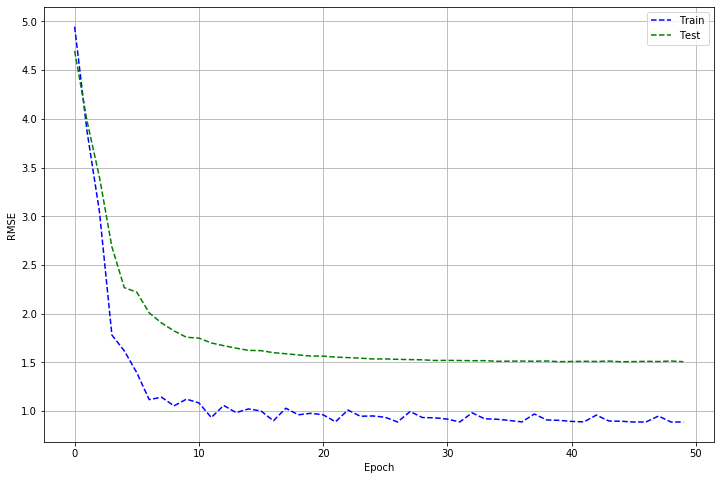

In [12]:
plt.figure(figsize=(12,8))
plt.plot(range(len(rmse_trace)), rmse_trace, 'b--', label='Train')
plt.plot(range(len(rmse_test_trace)), rmse_test_trace, 'g--', label='Test')
plt.grid(True)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.show()

### Using the model for Recommendations

We have now created a model to describe users and items in terms of latent vectors. We fitted them to reconstruct ratings by multiplication. So for obtaining recommendations we simply multiply user-item latent vectors we are interested in and see favorable combinations where predicted ratings, i.e. the products, are rather high.

Thus, before writing the `get_recommendations` we first implement `get_prediction`.

**Task:** Implement `get_prediction` for predicting ratings for a user and all items or a set of provided items. Remember to remove _known positives_.

In [13]:
def get_prediction(user,
                   items: np.array = None,
                   remove_known_pos: bool = True) -> Dict[int, Dict[str, float]]:
    if items is None:
        if remove_known_pos:
            # Predict from unobserved items
            known_items = np.array(list(user_ratings[user].keys()))
            items = np.setdiff1d(data.items, known_items)
        else:
            items = np.array(data.items)
    if type(items) == np.int64:
        items = np.array([items])
    
    user_embed = user_factors[user - 1].reshape(1, -1)
    item_embeds = item_factors[items - 1].reshape(len(items), -1)
    
    # use array-broadcasting
    preds = np.sum(user_embed * item_embeds, axis=1)
    sorting = np.argsort(preds)[::-1]
    preds = {item: {'pred': pred} for item, pred in
             zip(items[sorting], preds[sorting])}

    return preds

In [14]:
item_predictions = get_prediction(1)

In [15]:
list(item_predictions.items())[:20]

[(1055, {'pred': 6.447471337059429}),
 (279, {'pred': 6.380863284005746}),
 (953, {'pred': 5.996115472169505}),
 (1517, {'pred': 5.7736058799224494}),
 (1469, {'pred': 5.747000105234243}),
 (694, {'pred': 5.699746884115531}),
 (1367, {'pred': 5.65608849635709}),
 (1160, {'pred': 5.647550839796219}),
 (1325, {'pred': 5.590977171553072}),
 (1631, {'pred': 5.55820294913908}),
 (1167, {'pred': 5.526388797376206}),
 (1343, {'pred': 5.5090168171160325}),
 (753, {'pred': 5.47225878361656}),
 (1352, {'pred': 5.464844572793105}),
 (1414, {'pred': 5.460864550673042}),
 (134, {'pred': 5.452351195533388}),
 (474, {'pred': 5.446589101274951}),
 (1449, {'pred': 5.429391085743485}),
 (1640, {'pred': 5.423582140698597}),
 (1004, {'pred': 5.376135129172911})]

In [16]:
def get_recommendations(user: int, N: int, remove_known_pos: bool = False) -> List[Tuple[int, Dict[str, float]]]:
    predictions = get_prediction(user, remove_known_pos=remove_known_pos)
    recommendations = []
    for item, pred in predictions.items():
        add_item = (item, pred)
        recommendations.append(add_item)
        if len(recommendations) == N:
            break

    return recommendations

In [17]:
recommendations = get_recommendations(1, 10)

In [18]:
recommendations

[(1055, {'pred': 6.447471337059429}),
 (279, {'pred': 6.380863284005746}),
 (953, {'pred': 5.996115472169505}),
 (1517, {'pred': 5.7736058799224494}),
 (1469, {'pred': 5.747000105234243}),
 (694, {'pred': 5.699746884115531}),
 (1367, {'pred': 5.65608849635709}),
 (1160, {'pred': 5.647550839796219}),
 (1325, {'pred': 5.590977171553072}),
 (114, {'pred': 5.57759962974062})]

### Evaluation

In [19]:
N = 10

In [20]:
relevant_items = get_relevant_items(data.test_ratings)

In [21]:
users = relevant_items.keys()
prec_at_N = dict.fromkeys(data.users)

for user in users:
    recommendations = get_recommendations(user, N, remove_known_pos=True)
    recommendations = [val[0] for val in recommendations]
    hits = np.intersect1d(recommendations,
                          relevant_items[user])
    prec_at_N[user] = len(hits)/N

In [22]:
recommendations

[119, 1450, 113, 1189, 1130, 1495, 512, 889, 884, 1367]

In [23]:
np.mean([val for val in prec_at_N.values() if val is not None])

0.008723404255319148